# Exercise 9 by Timo Marks
I only upload the Jupyter Notebook because I think this is much easier to understand. 
Alle Anmerkungen dürfen gerne auf Deutsch gemacht werden. Es war nur Gewöhnungssache, dass ich Kommentare im Code auf Englisch schreibe.

In [1]:
# Done by Timo Marks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.preprocessing import StandardScaler
import mnist
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

## Function for: 
Loading image data    
Converting data matrix to feature vector, and normalization    
Adding a row of dummy ones to the feature vector to avoid offset term    
Normalize data to (0,1]  
Masking Data for specific digits  

In [2]:
def MnistRead():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()

    print('train_images: ' + str(train_images.shape))
    print('train_labels: ' + str(train_labels.shape))
    print('test_images:  '  + str(test_images.shape))
    print('test_labels:  '  + str(test_labels.shape))
    return [train_images, train_labels, test_images, test_labels]

# Creates num_grid * num_grid subplot of images
def MnistShow(images, num_grid_row = 4, num_grid_column = 4):
    plt.set_cmap("gray")
    fig, ax = plt.subplots(num_grid_row, num_grid_column, figsize=(3*num_grid_column,3*num_grid_row), sharex=True, sharey=True, subplot_kw = subplot_keywords)
    for i in range(num_grid_row):
        for j in range(num_grid_column):
            ax[i,j].imshow(images[i*num_grid_column+j])
    plt.show()


# Create a feature vector of each image
# One Column = One picture = One feature vector
def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    # This is wrong: See Note Nr. 1 at the end
    # images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

    images = images.transpose()
    # Add dummy ones --> one column now 785 numbers
    images = np.vstack([np.ones(images.shape[1]), images])
    return images

# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # Remove dummy ones
    feature_vector = feature_vector[1:]
    feature_vector = feature_vector.transpose()
    return feature_vector.reshape(feature_vector.shape[0], NCol, NRow) # Original shape

# Normalization: Gray Value from 0 to 1
def normalize(images):
    # This is called "normalization" in Matlab but actually you do a standardization (For Ex. 5-7)
    # return (images - images.mean())/images.std()
    # The true normalization between 0 and 1
    return images/np.max(images)

# Array containing only the specific numbers
def masking_data(images, labels, digit):
    digit_mask = labels[0,:] == digit
    images_digit = images[digit_mask]
    digit_mask = np.expand_dims(digit_mask, axis=0)
    labels_digit = labels[digit_mask]

    return [images_digit, labels_digit]

### 1. Read in Data and Visualization

In [3]:
[train_images, train_labels, test_images, test_labels] = MnistRead()
train_images = normalize(train_images)
test_images = normalize(test_images)

# Pick out specific numbers
digit_A = 0
digit_B = 4

# Array containing both numbers
# train_labels_mask = np.asarray(train_labels[:] == digit_A) | (train_labels[:] == digit_B)
# train_images, train_labels = train_images[train_labels_mask,:,:], train_labels[train_labels_mask]

# test_labels_mask = np.asarray(test_labels[:] == digit_A) | (test_labels[:] == digit_B)
# test_images, test_labels = test_images[test_labels_mask,:,:], test_labels[test_labels_mask]

# Explaination: train_labels.shape is (x,)
# When we will use matrix multiplication with dimensions like: (1,x) * (x,1) = scalarproduct
# We cannot use the (x,) vectors and (x,).tranpose yields to (x,)
# Therefore expand dimensions explicitly to (x,1) 
# In numpy (x,) is the vector (or more like a list) and (x,1) a matrix

train_labels = np.expand_dims(train_labels, axis=0)
test_labels = np.expand_dims(test_labels, axis=0)

[train_images_digit_A, train_labels_digit_A] = masking_data(train_images, train_labels, digit_A)
[train_images_digit_B, train_labels_digit_B] = masking_data(train_images, train_labels, digit_B)
[test_images_digit_A, test_labels_digit_A] = masking_data(test_images, test_labels, digit_A)
[test_images_digit_B, test_labels_digit_B] = masking_data(test_images, test_labels, digit_B)

train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


<Figure size 432x288 with 0 Axes>

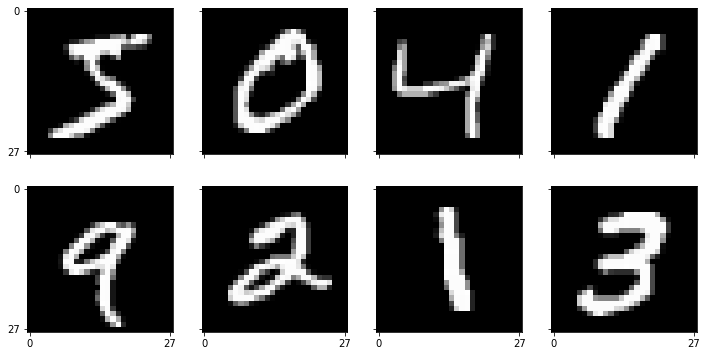

<Figure size 432x288 with 0 Axes>

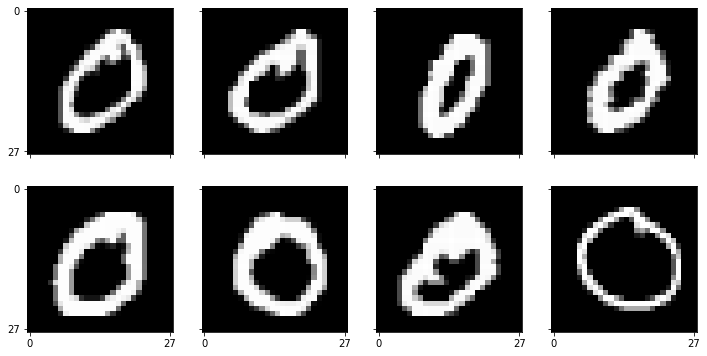

In [4]:
MnistShow(train_images, num_grid_row=2,num_grid_column=4) # Both digits
MnistShow(train_images_digit_A, num_grid_row=2,num_grid_column=4) # Only Digit B

## Task 4 Converting data matrix to feature vector: Test Images
If this fails, the upcoming calculation are not correct. Make sure the images are the same

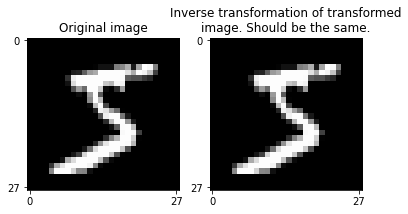

In [5]:
(NFrame, NRow, NCol) = train_images.shape
feature_vectors = matrix2vector(train_images)
images = vector2matrix(feature_vectors, NRow, NCol)

fig, ax = plt.subplots(1,2, figsize=(6,3), subplot_kw=subplot_keywords)
ax[0].imshow(train_images[0])
ax[1].imshow(images[0])
ax[0].set_title("Original image")
ax[1].set_title("Inverse transformation of transformed\nimage. Should be the same.")
plt.plot();

In [120]:
# This is "y hat" on the exercise sheet
def sigmoid(exp_argument):
    return 1.0/(1+np.exp(-exp_argument)) # shape = (1,N)

def sigmoid_derivative(exp_argument):
    return sigmoid(-exp_argument) (1-sigmoid(-exp_argument))

# Returns a vector of the best class labels for all the samples 
def nn_forward(vec_w, mat_X, NInput, NHidden, NOutput):
    # Number samples = Number Columns = S
    # Number Pixel/Input = Number Columns = NInput
    # mat_X of shape (NInput,N)
    S = mat_X.shape[1]

    # i=input, j=hidden, k=output
    mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
    mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

    vec_bestclass = np.array([])
    for sample in np.arange(S):
        layer_hidden = mat_wij @ mat_X[:,sample] # shape: (NHidden, NInput) @ (NInput,1) = (NHidden,1)
        layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
        layer_hidden = sigmoid(layer_hidden)
        # vec_output_hidden = np.append(vec_output_hidden, output_hidden)

        layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
        layer_output = sigmoid(layer_output)

        vec_bestclass = np.append(vec_bestclass, np.argmax(layer_output))
        vec_bestclass = np.expand_dims(vec_bestclass, axis=0)
    return vec_bestclass

# Converts digits to vec of zero and ones: 7 -> (0,0,0,0,0,0,0,1,0,0)
def digit_to_binary_vec(vec_digits, NOutputs):
    vec_digits = vec_digits.flatten()
    mat_vec_binary = np.zeros((NOutput, len(vec_digits)))
    for i in np.arange(len(vec_digits)):
        mat_vec_binary[vec_digits[i],i] = 1 # shape: (NOutputs, vec_digits)
    return mat_vec_binary

Example for digits_to_binary_vec

In [104]:
print(train_labels[0,0:3])
print(digit_to_binary_vec(train_labels[0,0:3],10))



[5 0 4]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [116]:
train_images_feature_vec = matrix2vector(train_images)
mat_X = train_images_feature_vec
vec_true = digit_to_binary_vec(train_labels,10)

NInput = 785
NHidden = 11
NOutput = 10
vec_w = np.zeros(NInput*NHidden+NHidden*NOutput)+0.1

In [119]:
# i=input, j=hidden, k=output
vec_X = mat_X[:,1]
vec_true_y = vec_true[:,1]

mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

layer_hidden = mat_wij @ vec_X
layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
layer_hidden = sigmoid(layer_hidden)
# vec_output_hidden = np.append(vec_output_hidden, output_hidden)
# print(f"mat_wjk: {mat_wjk.shape}, layer_hidden: {layer_hidden.shape}")
layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
layer_output = sigmoid(layer_output) # (NOutput,1)

y_estimate = layer_output
print(f"layer_output: {layer_output.shape}")
y_estimate[y_estimate[:] == 0] += 10**-10
y_estimate[y_estimate[:] == 1] -= 10**-10

# Cross entropy loss function
L = -1/NOutput * np.sum(vec_true_y*np.log(y_estimate)+(1-vec_true_y)*np.log(1-y_estimate)) # scalar


# grad_L must have same dimensions as vec_w
grad_L = []
grad_jk = np.array([])

# Get all weights for each neuron in hidden layer = one row of mat_wjk (all k's)
# After that concatenate the weights for each neuron in the hidden layer for one vector
for H in range(NHidden):
    mat_wjk_H = np.expand_dims(mat_wjk[:,H], axis=1)
    # print(f"mat_wjk[h,:]: {mat_wjk_h.shape}")
    # Elementwise multiplication 
    grad_jk_H = 1/NHidden*np.multiply((y_estimate-vec_true_y), mat_wjk_h)
    grad_jk = np.append(grad_jk, grad_jk_H)
    
# Second part of the weight vectors
grad_ij = np.array([])
for I in range(NInput):
    mat_wij_I = np.expand_dims(mat_wij[:,I], axis=1)
    # print(f"mat_wjk[h,:]: {mat_wjk_h.shape}")
    # Elementwise multiplication 
    grad_ij_I = 1/NInput*np.multiply((y_estimate-vec_true_y), mat_wij_I)
    grad_ij = np.append(grad_ij, grad_ij_I)


grad_L.append(grad_jk)
grad_L = np.array(grad_L)

layer_output: (10, 1)


In [92]:
# Outputs cross entropy loss function and its gradient
def nn_gradient(vec_w, vec_X, vec_true_y, NInput, NHidden, NOutput):
    # i=input, j=hidden, k=output
    mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
    mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

    layer_hidden = mat_wij @ vec_X
    layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
    layer_hidden = sigmoid(layer_hidden)
    # vec_output_hidden = np.append(vec_output_hidden, output_hidden)
    # print(f"mat_wjk: {mat_wjk.shape}, layer_hidden: {layer_hidden.shape}")
    layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
    layer_output = sigmoid(layer_output) # (NOutput,1)

    y_estimate = layer_output
    print(f"layer_output: {layer_output.shape}")
    y_estimate[y_estimate[:] == 0] += 10**-10
    y_estimate[y_estimate[:] == 1] -= 10**-10

    # Cross entropy loss function
    L = -1/NOutput * np.sum(vec_true_y*np.log(y_estimate)+(1-vec_true_y)*np.log(1-y_estimate)) # scalar
    
    grad_L = []
    grad_jk = []
    # Get all weights for each neuron in hidden layer = one row of mat_wjk (all k's)
    # After that concatenate the weights for each neuron in the hidden layer for one vector
    for h in range(NHidden):
        mat_wjk_h = np.expand_dims(mat_wjk[h,:], axis=1)
        # print(f"mat_wjk[h,:]: {mat_wjk_h.shape}")
        # Elementwise multiplication 
        grad_jk_h = 1/NHidden*np.multiply((y_estimate-vec_true_y), mat_wjk_h)
        grad_jk.append(grad_jk_h)
    
    

    grad_L.append(np.array(grad_jk).flatten())
    grad_L = np.array(grad_L)
    return (L, grad_L)

# Minimizes 
def minimize(loss_function, vec_w, mat_X, vec_true_y, NInput, NHidden, NOutput, learning_rate=0.01, max_Iter=100):
    # Number samples
    S = mat_X.shape[1]
    L_history = np.array([])
    for i in range(max_Iter):
        # Save loss function after each epoch
        [L, grad_L] = loss_function(vec_w, mat_X[:,i], vec_true_y, NInput, NHidden, NOutput)
        L_history = np.append(L_history,L)

        # One whole epoch of all samples
        for sample in range(S):
            [L, grad_L] = loss_function(vec_w, mat_X[:,i], vec_true_y, NInput, NHidden, NOutput)
            vec_w = vec_w - learning_rate * grad_L

            if (i % 10 == 1):
                learning_rate = learning_rate * 0.8
    # Returns optimal weight vector and history of loss function
    return [vec_w, L_history] 

def compute_accuracy(vec_bestclass, vec_true_label):
    vec_true_false = vec_true_label[vec_bestclass == vec_true_label]
    return len(vec_true_false)/len(vec_true_label[0])

# a = compute_accuracy(vec_bestclass, train_labels)


In [93]:
vec_digits = train_labels
length = vec_digits.shape[1]
mat_vec_binary = np.zeros((NOutput, length))
for i in np.arange(length):
    a = vec_digits[0,i]
    mat_vec_binary[vec_digits[0,i],i] = 1 # shape: (NOutputs, vec_digits)

In [78]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
mat_X = train_images_feature_vec
vec_true_y = digit_to_binary_vec(train_labels,10)

NInput = 785
NHidden = 10
NOutput = 10

vec_w_init = np.zeros(NInput*NHidden+NHidden*NOutput)+0.1

# Gradient Descent of Cross entropy loss function
# nn_gradient_param = [vec_w_init, mat_X, vec_true_y, NInput, NHidden, NOutput]
# [vec_w_optimal, L_history] = minimize(nn_gradient, *nn_gradient_param, learning_rate=0.01, max_Iter=100)

(L,grad_L)=nn_gradient(vec_w_init, mat_X[:,1], vec_true_y[:1], NInput, NHidden, NOutput)
# vec_bestclass = nn_forward(vec_w_optimal, mat_X, NInput, NHidden, NOutput)
# compute_accuracy(vec_bestclass, train_labels)

layer_output: (10, 1)


In [ ]:
vec_true_false = train_labels[train_labels == train_labels]


### Task 6: Perform Logistic Regression Gradient

In [113]:
def gradient_descent_logreg(max_iter, step_size, vec_w_init, mat_X, mat_X_digits, evolution_iteration_list = [0], tikhonov=False, lambda_para = 1):
    # Number Samples = Number Columns
    N = mat_X.shape[1]
    # Convert the vector of true label mat_X_digits to binary num(0,1) <-> digit(A, B)
    vec_y = map_digit_to_vec_y(mat_X_digits)
    vec_L = []
    evolution_optimal_w_vec = [] # For plot of weight matrix evolution
    for i in np.arange(max_iter):
        # Estimation of y --> y hat
        y_estimate = vec_y_estimate(vec_w_init, mat_X) # shape = (1,N)

        # Handle the cases where we would take log  of 0: in y_estimate or 1-y_estimate
        y_estimate[y_estimate[:] == 0] += 10**-10
        y_estimate[y_estimate[:] == 1] -= 10**-10
        
        # Cross entropy loss function
        L = -1/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate)) # scalar
        vec_L.append(L)

        # Gradient Descent Algorithm - With or Without Regularization
        if tikhonov: grad_L= 1/N*(np.matmul(mat_X,(y_estimate-vec_y).transpose()) + lambda_para * vec_w_init)
        else: grad_L= 1/N*np.matmul(mat_X,(y_estimate-vec_y).transpose())

        if i in evolution_iteration_list:
            evolution_optimal_w_vec.append(vec_w_init)

        # Decrease step_size with evolution slowly
        if (i % 20 == 1):
            step_size = step_size * 0.9
        vec_w_init = vec_w_init - step_size * grad_L
        ### Explanation
        # For the gradient of L(w) I rewrote the sum
        # We have the shapes: (y_estimate-vec_y).shape=(1, N)
        #                     mat_X.shape=(785, N)
        # The sum says, take entry i of (y_estimate-vec_y) and multiply it with vector mat_X[i]
        # which is one whole column. This is the same as mat_X * (y_estimate-vec_y).transpose() and in shapes
        # (785, N) * (N, 1) = (785,1)
        # So the summation over all N samples is hidden in the matrix multiplication for each row in mat_X
        

    return (vec_L, vec_w_init, evolution_optimal_w_vec)

# This is "y hat" on the exercise sheet
def vec_y_estimate(vec_w_init, mat_X):
    exp_argument = np.matmul(vec_w_init.transpose(), mat_X) # shape = (1,N)
    return 1.0/(1+np.exp(-exp_argument)) # shape = (1,N)

# The computation should work for any number (A,B). Map this to (0,1)
def map_digit_to_vec_y(mat_X_digits):
    vec_y = np.zeros((1,mat_X_digits.shape[1])) # digit A entries to 0
    digit_B_mask = mat_X_digits[0,:] == digit_B
    digit_B_mask = np.expand_dims(digit_B_mask,axis=0)  # Shape (1,N)
    vec_y[digit_B_mask] = 1  # digit B entries to 1
    return vec_y
    
# Function Call predict_one_y(optimal_w_vec, train_images_feature_vec[:,i], digit_A, digit_B)
# Correct number can be seen in train_labels/test_labels array
def predict_one_y (vec_w_opt_lda, x, digit_A, digit_B):
    vec_y_lda = vec_y_estimate(vec_w_opt_lda, x)
    # Probability vec_y_lda is the probability of label "1" thus digit B.
    if vec_y_lda > 0.5: 
        return digit_B
    else:
        return digit_A

#### Plot the evolution of the loss function, the final weights matrix and the evolution of the initial (iteration nr. = 0 ) weights matrix at some other iteration steps
You can see that only slights changes to the weights matrix are made after the first iteration.

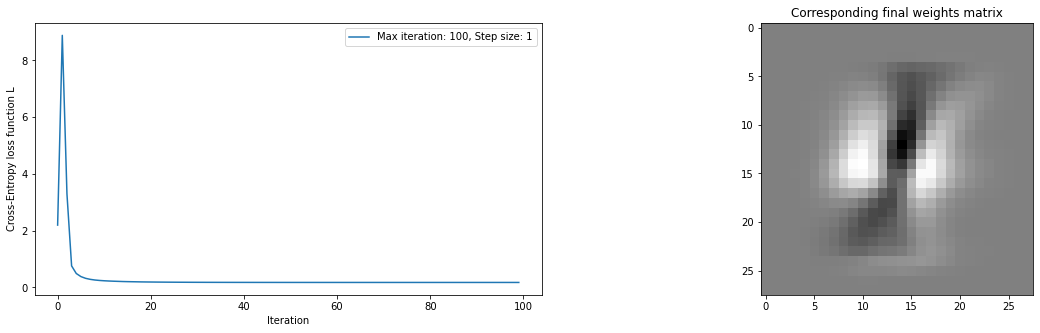

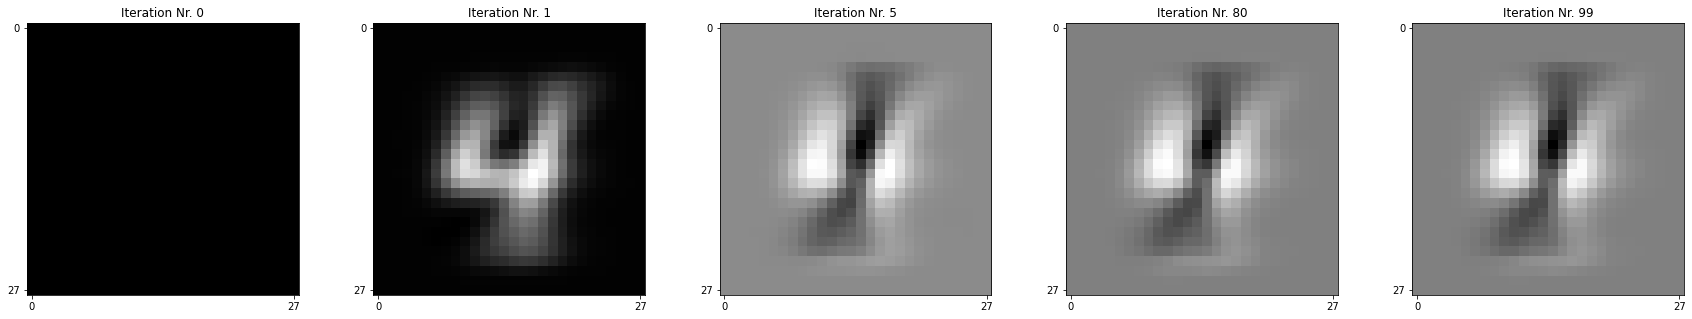

In [114]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1

max_iter = 100
step_size = 1
evolution_list = [0,1,5,80,max_iter-1]
(vec_L, optimal_w_vec, evolution_optimal_w_vec) = gradient_descent_logreg(max_iter, step_size, vec_w_init, train_images_feature_vec, train_labels, evolution_list)
optimal_w_mat = vector2matrix(optimal_w_vec, NRow, NCol)

# Plot Results
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(vec_L, label=f"Max iteration: {max_iter}, Step size: {step_size}")
ax[1].imshow(optimal_w_mat[0])

ax[0].legend()
ax[1].set_title("Corresponding final weights matrix")

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Cross-Entropy loss function L")

# Evolution of optimal weight matrix
fig, ax = plt.subplots(1,len(evolution_list),figsize=(30,5), subplot_kw = subplot_keywords)
for i, (weight_mat, e_list) in enumerate(zip(evolution_optimal_w_vec, evolution_list)):
    ax[i].imshow(vector2matrix(weight_mat, NRow, NCol)[0])
    ax[i].set_title(f"Iteration Nr. {e_list}")

### Task 7: Model Accuracy
The method gives a high accuracy around 97%. The Accuracy depends on the used numbers but is slightly worse than the LDA from the last exercise.

In [115]:
def compute_accuracy(vec_y_est, vec_y_true, digit_A, digit_B):
    vec = np.zeros((1,vec_y_est.shape[1]))
    vec[vec_y_est[:] > 0.5] = digit_B
    vec[vec_y_est[:] <= 0.5] = digit_A
    vec_true_false = vec[vec == vec_y_true]

    return len(vec_true_false)/len(vec_y_true[0])

In [116]:
vec_y_est = vec_y_estimate(optimal_w_vec, matrix2vector(train_images))
accuracy = compute_accuracy(vec_y_est, train_labels, digit_A, digit_B)
print(f"Train data: The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

vec_y_est = vec_y_estimate(optimal_w_vec, matrix2vector(test_images))
accuracy = compute_accuracy(vec_y_est, test_labels, digit_A, digit_B)
accuracy_test_no_reg = accuracy
print(f"Test data:  The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

Train data: The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.98721
Test data:  The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.99103


### Task 8: Test model with test dataset and show the classification

The model predicts the numbers pretty good although the accuracy from above is not as high as by the LDA from the last exercise.

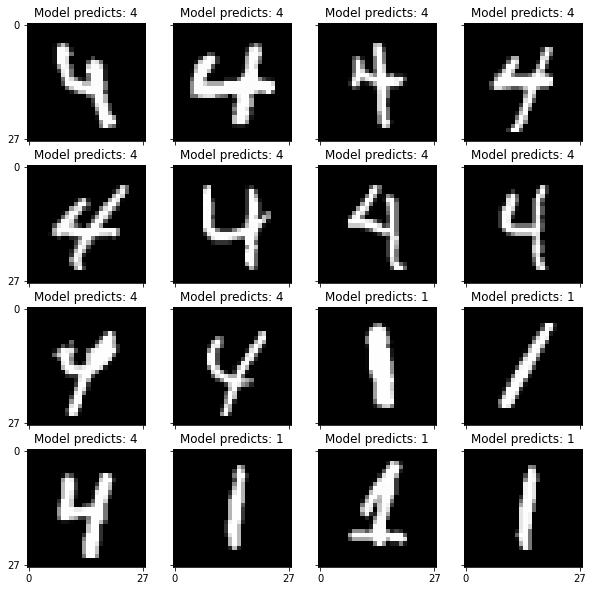

In [117]:
num_grid = 4
fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), subplot_kw=subplot_keywords, sharex=True, sharey=True)

test_images_vec = matrix2vector(test_images)
for i in np.arange(num_grid):
    for j in np.arange(num_grid):
    # Take some random examples from the test dataset and show the prediction
        max_int = test_images_vec.shape[1]
        rand = np.random.randint(0, max_int)
        Example_data = test_images_vec[:,rand]
        prediction = predict_one_y(optimal_w_vec, Example_data, digit_A, digit_B)
        ax[i,j].imshow(test_images[rand])
        ax[i,j].set_title(f"Model predicts: {prediction}")
plt.show()

### Task 9: Tikhonov Regularization for Logistic Regression
Here we see the new weights matrix for a specific $\lambda$ parameter

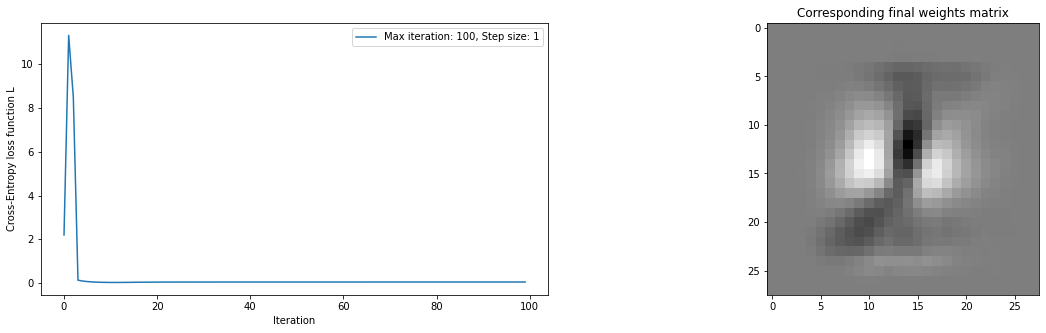

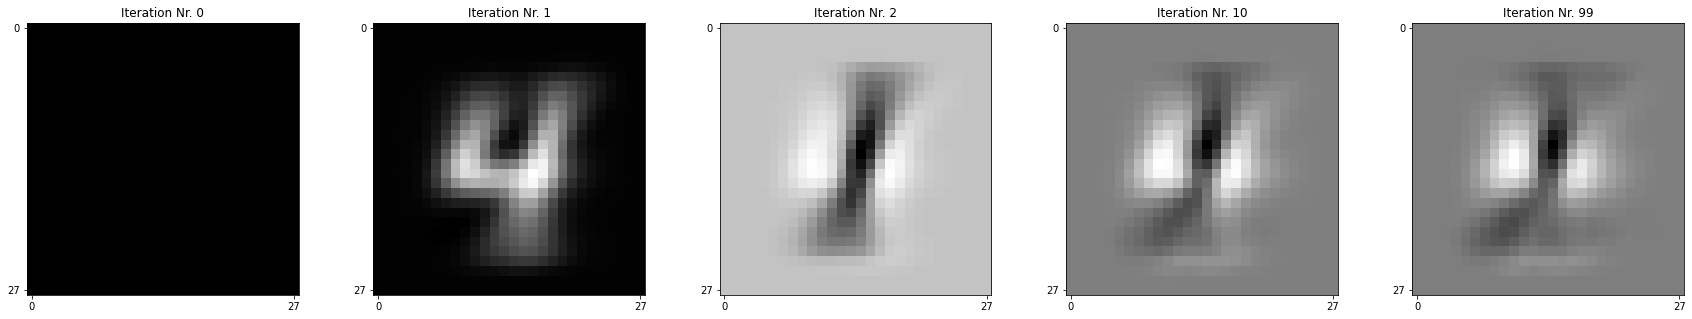

In [118]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1

max_iter = 100
step_size = 1
evolution_list = [0,1,2,10,max_iter-1]
lambda_para = 5000
(vec_L, optimal_w_vec, evolution_optimal_w_vec) = gradient_descent_logreg(max_iter, step_size, vec_w_init, train_images_feature_vec, train_labels, evolution_list, tikhonov=True, lambda_para=lambda_para)
optimal_w_mat = vector2matrix(optimal_w_vec, NRow, NCol)

# Plot Results
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(vec_L, label=f"Max iteration: {max_iter}, Step size: {step_size}")
ax[1].imshow(optimal_w_mat[0])

ax[0].legend()
ax[1].set_title("Corresponding final weights matrix")

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Cross-Entropy loss function L")

# Evolution of optimal weight matrix
fig, ax = plt.subplots(1,len(evolution_list),figsize=(30,5), subplot_kw = subplot_keywords)
for i, (weight_mat, e_list) in enumerate(zip(evolution_optimal_w_vec, evolution_list)):
    ax[i].imshow(vector2matrix(weight_mat, NRow, NCol)[0])
    ax[i].set_title(f"Iteration Nr. {e_list}")

 The accuracy increases by another percent

In [119]:
vec_y_est = vec_y_estimate(optimal_w_vec, matrix2vector(train_images))
accuracy = compute_accuracy(vec_y_est, train_labels, digit_A, digit_B)
print(f"Train data: The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

vec_y_est = vec_y_estimate(optimal_w_vec, matrix2vector(test_images))
accuracy = compute_accuracy(vec_y_est, test_labels, digit_A, digit_B)
print(f"Test data:  The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

Train data: The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.99301
Test data:  The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.99622


### Comaprison across multiply $\lambda$ values
A negative $\lambda$ parameter increases the "black 1" in the final weights matrix and decreases the accuracy with the test set. A large positive $\lambda$ increases darkens the "background" of the weight matrix and highlights the 4 in the weights matrix. The accuracy increases but only at sufficient large $\lambda$ values. Otherwise the accuracy decreases a little bit ~ 0.1% in comparison without the tikhonov regularization. Furthermore, with a large $\lambda$ the loss function decreases faster 

Test Data accuracy

No Regularization:	 The Accuracy is: 0.9910250354
lambda = 0.0E+00:	 The Accuracy is: 0.9910250354
lambda = 5.0E+01:	 The Accuracy is: 0.9910250354
lambda = 1.0E+03:	 The Accuracy is: 0.9905526689
lambda = 5.0E+03:	 The Accuracy is: 0.9962210675
lambda = 1.0E+04:	 The Accuracy is: 0.9938592348


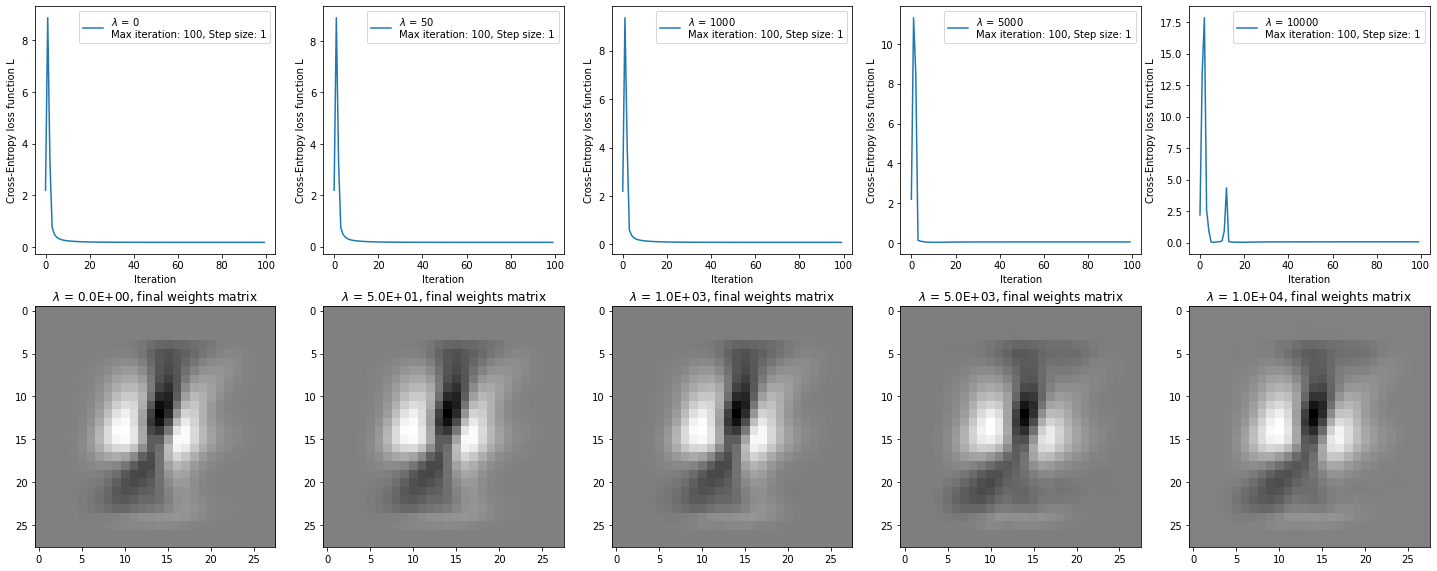

In [120]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
max_iter = 100
step_size = 1
lambda_para = [0, 50, 1_000, 5_000, 10_000]
fig, ax = plt.subplots(2,len(lambda_para),figsize=(len(lambda_para)*5,10))
print("Test Data accuracy\n")
print(f"No Regularization:\t The Accuracy is: {accuracy_test_no_reg:.10f}")

for i, l in enumerate(lambda_para):
    vec_w_init = np.zeros((NRow*NCol+1,1))+0.1
    
    (vec_L, optimal_w_vec, evolution_optimal_w_vec) = gradient_descent_logreg(max_iter, step_size, vec_w_init, train_images_feature_vec, train_labels, evolution_list, tikhonov=True, lambda_para=l)
    optimal_w_mat = vector2matrix(optimal_w_vec, NRow, NCol)

    # Plot Results
    ax[0][i].plot(vec_L, label=f"$\lambda$ = {l}\nMax iteration: {max_iter}, Step size: {step_size}")
    ax[1][i].imshow(optimal_w_mat[0])

    ax[0][i].legend()
    ax[1][i].set_title(f"$\lambda$ = {l:.1E}, final weights matrix")

    ax[0][i].set_xlabel("Iteration")
    ax[0][i].set_ylabel("Cross-Entropy loss function L")
    
    vec_y_est = vec_y_estimate(optimal_w_vec, matrix2vector(test_images))
    accuracy = compute_accuracy(vec_y_est, test_labels, digit_A, digit_B)
    print(f"lambda = {l:.1E}:\t The Accuracy is: {accuracy:.10f}")


# Notes

In [121]:
# Nr. 1
# Use:
# images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
# images = images.transpose()

# Instead of this without tranpose
# images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

# Explaination
images = np.array([[[1.1,1.2],[1.3,1.4]], [[2.1,2.2],[2.3,2.4]], [[3.1,3.2],[3.3,3.4]]])
print(images.shape) # --> Just like (N,28,28) as in mnist
print("Before Reshape\n", images, "\n")
images_correct = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
images_correct = images_correct.transpose()
print("Correct Reshape: Each Column is one feature vector = one image", images_correct, "\n")

images_wrong = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 
print("Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column", images_wrong)

(3, 2, 2)
Before Reshape
 [[[1.1 1.2]
  [1.3 1.4]]

 [[2.1 2.2]
  [2.3 2.4]]

 [[3.1 3.2]
  [3.3 3.4]]] 

Correct Reshape: Each Column is one feature vector = one image [[1.1 2.1 3.1]
 [1.2 2.2 3.2]
 [1.3 2.3 3.3]
 [1.4 2.4 3.4]] 

Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column [[1.1 1.2 1.3]
 [1.4 2.1 2.2]
 [2.3 2.4 3.1]
 [3.2 3.3 3.4]]
